BioIB application in the context of developing macrophages (Data from https://www.science.org/doi/10.1126/science.abo0510)

In [ ]:
from bioib import bioib, utils, plotting

In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
adata=sc.read_h5ad('filtered_processed_macrophage_adata.h5ad')
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var_names_make_unique()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
n_genes=500
sc.pp.highly_variable_genes(adata, n_top_genes=n_genes)
adata_hvg = adata[:, adata.var["highly_variable"]]
adata=adata_hvg.copy()
adata.shape

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(108197, 500)

In [26]:
organ_label_dict={'KI':'Kidney',
                  'LI': 'Liver',
                  'SK': 'Skin',
                  'SP': 'Spleen',
                  'YS': 'Yolk sac'}

adata_hvg.obs['Organ']=[organ_label_dict[o] for o in adata_hvg.obs['organ']]

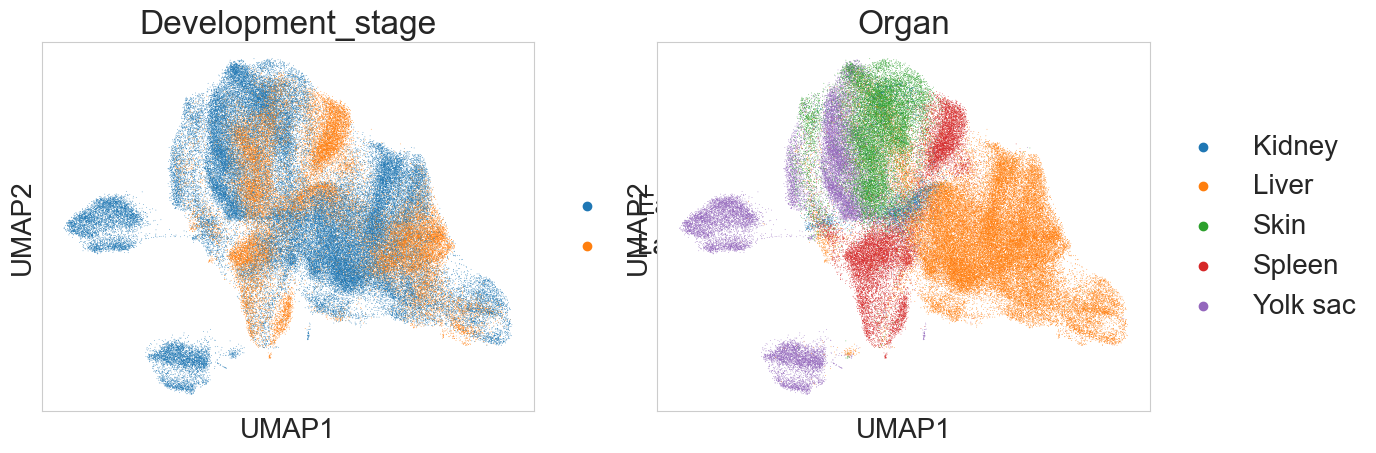

In [4]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
with plt.rc_context():
    sc.pl.umap(adata, color=['Development_stage', 'Organ'],show=False)
    plt.show()

In [5]:
signal_of_interest = 'Development_stage'
groups_of_interest = list(np.unique(adata.obs[signal_of_interest]))
bioib_stage = bioib.bioIB(
    adata=adata_hvg,
    signal_of_interest=signal_of_interest,
    groups_of_interest=groups_of_interest,
    beta=30,
    num_betas=100,
    bulk=True,
    copy=True)

adata_stage=bioib_stage.compress()

beta=30.000000000000004
beta=25.264992354301576
beta=21.277327955430565
beta=17.919050937130677
beta=15.0908228307649
beta=12.708984114646492
beta=10.703079549582789
beta=9.01377409958969
beta=7.591097790317835
beta=6.392967587771188
beta=5.383942574211228
beta=4.534175599114845
beta=3.8185303948232434
beta=3.2158380409959135
beta=2.7082707839477966
beta=2.2808146883273137
beta=1.9208255220722767
beta=1.6176547376367798
beta=1.3623344859430986
beta=1.1473123457117917


In [9]:
import pickle
with open("bioib_object_stage.pkl", "wb") as f:
    pickle.dump(bioib_stage, f)

In [58]:
gene_to_metagene = adata_stage.uns["bioIB_gene_MG_mapping"]
cell_to_metagene = adata_stage.uns['bioIB_MG_group_of_interest_mapping']
compressed_data = adata_stage.obsm['bioIB_compressed_data']

In [59]:
metagene_order=np.argsort(cell_to_metagene[0,:])[::-1]

In [60]:
gene_to_metagene=gene_to_metagene[:, metagene_order]
cell_to_metagene=cell_to_metagene[:, metagene_order]
compressed_data=compressed_data[:, metagene_order]

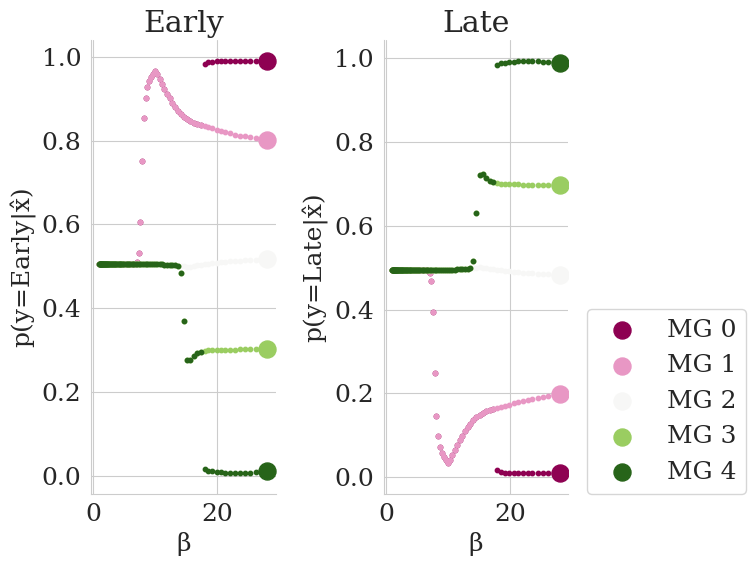

In [62]:
bioib.plot_bifurcations(bioib_stage, metagene_order=list(metagene_order),
                        cmap='PiYG',
                        # save_path='bifurcations_%s.png' % (signal_of_interest)
                        )

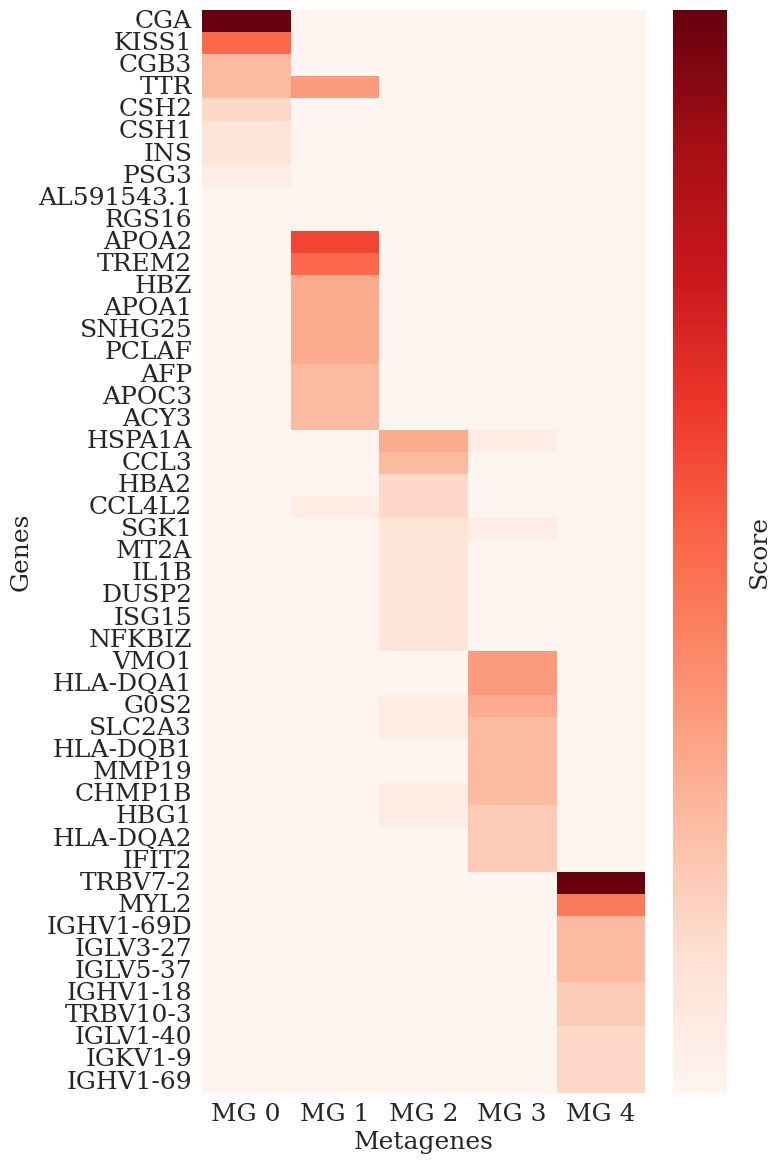

In [19]:
n_metagenes=gene_to_metagene.shape[1]
n_top_genes=10

chosen_indeces = []

for mtg in range(n_metagenes):
    representative_genes_arr = np.argsort(gene_to_metagene[:, mtg])[::-1][:n_top_genes]
    for g in representative_genes_arr:
        if g not in chosen_indeces:
            chosen_indeces.append(g)
gene_labels = np.array(adata_stage.var_names)[chosen_indeces]

plt.figure(figsize=(8,12))
ax=sns.heatmap(gene_to_metagene[chosen_indeces, :],
                  # annot=True,
                  vmax=0.2,
                  xticklabels=['MG %s' %i for i in range(n_metagenes)],
                  yticklabels=gene_labels,
                  cmap='Reds',
          )
# Remove colorbar ticks
cbar = ax.collections[0].colorbar
cbar.set_ticks([])  # removes ticks
cbar.set_label('Score', labelpad=15)

plt.xlabel('Metagenes')
plt.ylabel('Genes')
plt.tight_layout()
plt.show()

In [20]:
compressed_adata=sc.AnnData(compressed_data)
n_metagenes=compressed_adata.shape[1]
for obs in adata_stage.obs:
    compressed_adata.obs[obs] = list(adata_stage.obs[obs])
metagene_names=['MG %s' % i for i in range(n_metagenes)]
compressed_adata.var_names=metagene_names
compressed_adata

AnnData object with n_obs × n_vars = 108197 × 5
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'Age_categorical', 'Development_stage', 'Metagene 0', 'Metagene 1', 'Metagene 2', 'Metagene 3', 'Metagene 4'

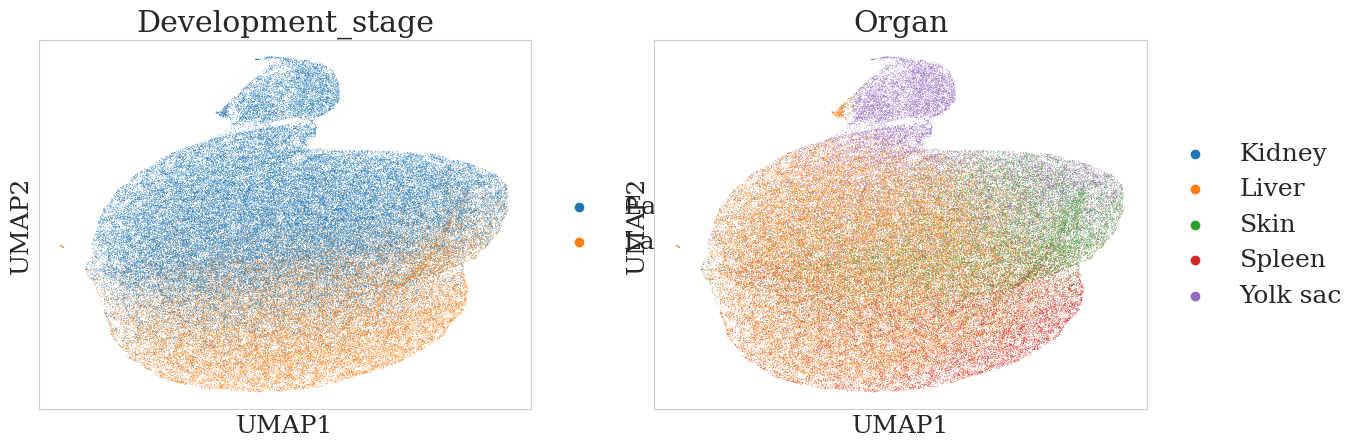

In [28]:
sc.pp.neighbors(compressed_adata)
sc.tl.umap(compressed_adata)
with plt.rc_context():
    sc.pl.umap(compressed_adata, color=['Development_stage', 'Organ'],show=False)
    plt.show()

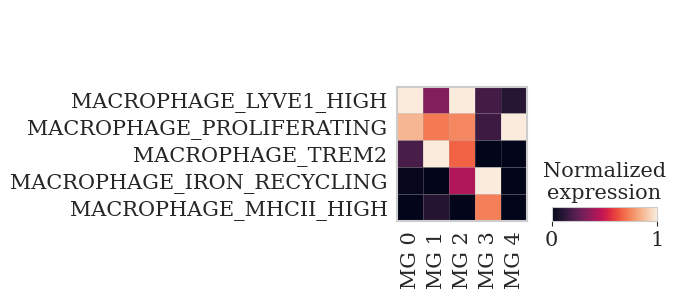

In [21]:
cat_order=['MACROPHAGE_LYVE1_HIGH',
           'MACROPHAGE_PROLIFERATING',
           'MACROPHAGE_TREM2',
           'MACROPHAGE_IRON_RECYCLING',
           'MACROPHAGE_MHCII_HIGH',
           ]
with plt.rc_context():
    sc.pl.matrixplot(compressed_adata,
                  var_names=metagene_names,
                  groupby='celltype_annotation',
                  standard_scale='var',
                  categories_order=cat_order,
                  colorbar_title='Normalized\nexpression',
                  show=False,)
    plt.show()

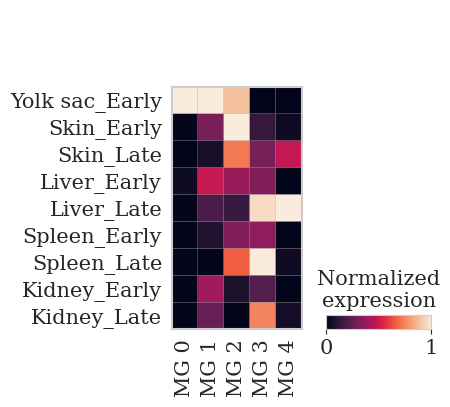

In [24]:
cat_order=['Yolk sac_Early',
           'Skin_Early',
           'Skin_Late',
           'Liver_Early',
           'Liver_Late',
           'Spleen_Early',
           'Spleen_Late',
           'Kidney_Early',
           'Kidney_Late',
           ]

with plt.rc_context():
    sc.pl.matrixplot(compressed_adata,
                  var_names=metagene_names,
                  groupby=['Organ', 'Development_stage'],
                  standard_scale='var',
                  categories_order=cat_order,
                  colorbar_title='Normalized\nexpression',
                  show=False,)
    plt.show()

SIGNAL OF INTEREST - ORGAN

Here we apply bioIB to the same data as before, but setting Organ as signal of interest, resulting in a different set of metagenes

In [27]:
signal_of_interest = 'Organ'
groups_of_interest = list(np.unique(adata_hvg.obs[signal_of_interest]))
bioib_organ = bioib.bioIB(
    adata=adata_hvg,
    signal_of_interest=signal_of_interest,
    groups_of_interest=groups_of_interest,
    beta=30,
    num_betas=100,
    bulk=True,
    copy=True)

adata_organ=bioib_organ.compress()

beta=30.000000000000004
beta=25.264992354301576
beta=21.277327955430565
beta=17.919050937130677
beta=15.0908228307649
beta=12.708984114646492
beta=10.703079549582789
beta=9.01377409958969
beta=7.591097790317835
beta=6.392967587771188
beta=5.383942574211228
beta=4.534175599114845
beta=3.8185303948232434
beta=3.2158380409959135
beta=2.7082707839477966
beta=2.2808146883273137
beta=1.9208255220722767
beta=1.6176547376367798
beta=1.3623344859430986
beta=1.1473123457117917


In [46]:
gene_to_metagene = adata_organ.uns["bioIB_gene_MG_mapping"]
cell_to_metagene = adata_organ.uns['bioIB_MG_group_of_interest_mapping']
compressed_data = adata_organ.obsm['bioIB_compressed_data']
print('bioIB generated %s metagenes' % gene_to_metagene.shape[1])

bioIB generated 43 metagenes


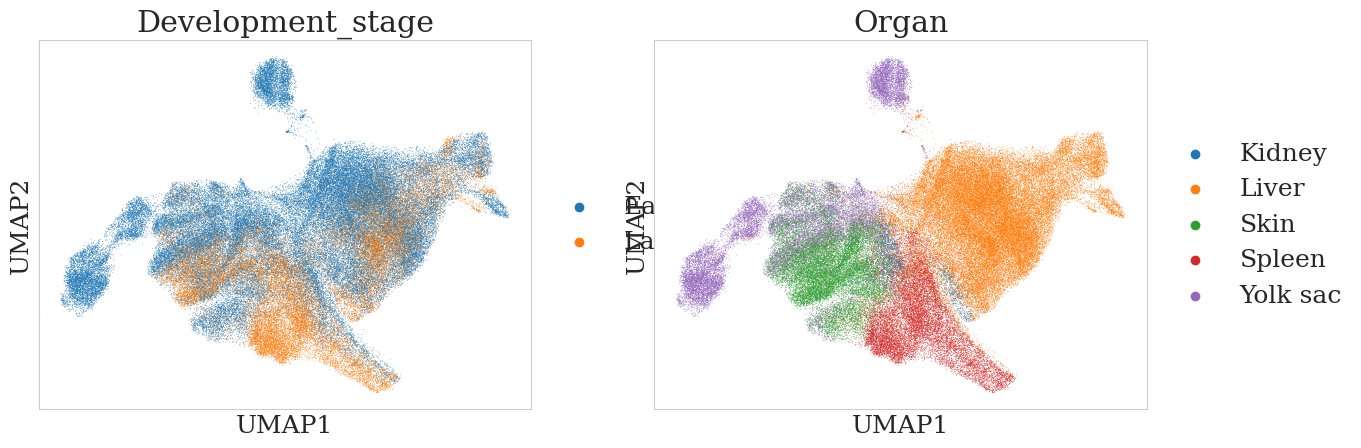

In [47]:
compressed_adata=sc.AnnData(compressed_data)
for obs in adata_organ.obs:
    compressed_adata.obs[obs] = list(adata_organ.obs[obs])
sc.pp.neighbors(compressed_adata)
sc.tl.umap(compressed_adata)
with plt.rc_context():
    sc.pl.umap(compressed_adata, color=['Development_stage', 'Organ'],show=False)
    plt.show()

In [48]:
n_leaves=7
adata_organ_7mg=bioib_organ.reannotate_adata(n_leaves=n_leaves)
gene_to_metagene = adata_organ_7mg.uns["bioIB_gene_MG_mapping"]
cell_to_metagene = adata_organ_7mg.uns['bioIB_MG_group_of_interest_mapping']
compressed_data = adata_organ_7mg.obsm['bioIB_compressed_data']
print('Reannotated adata contains %s metagenes' % gene_to_metagene.shape[1])

Reannotated adata contains 7 metagenes


In [49]:
ys_index=groups_of_interest.index('Yolk sac')
metagene_order=np.argsort(cell_to_metagene[ys_index,:])[::-1]

In [50]:
gene_to_metagene=gene_to_metagene[:, metagene_order]
cell_to_metagene=cell_to_metagene[:, metagene_order]
compressed_data=compressed_data[:, metagene_order]

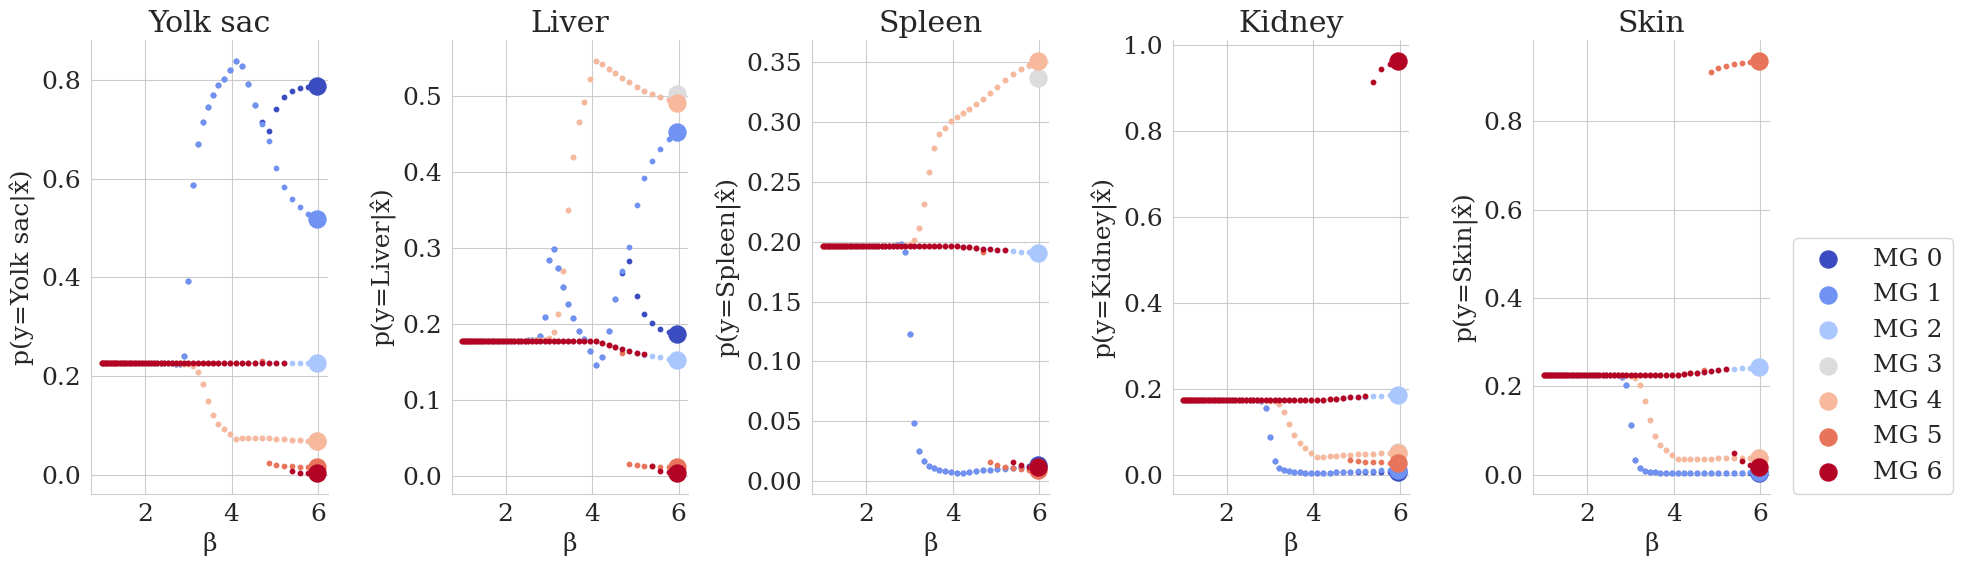

In [51]:
n_leaves=7
bioib.plot_bifurcations(bioib_organ,
                        n_leaves=n_leaves,
                        metagene_order=list(metagene_order),
                        cmap='coolwarm',
                        group_order=['Yolk sac', 'Liver', 'Spleen','Kidney', 'Skin'],
                        # save_path='bifurcations_%s.png' % (signal_of_interest)
                        )

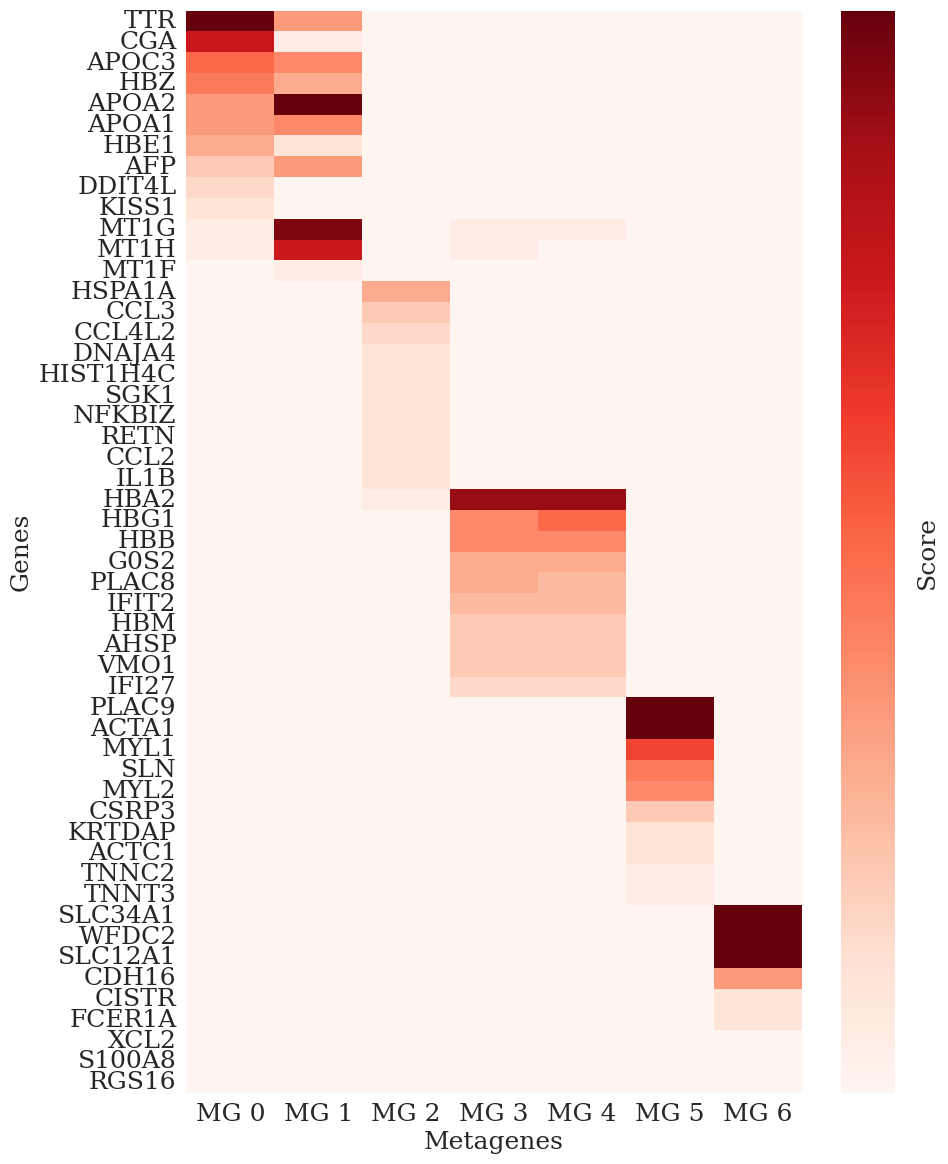

In [52]:
n_metagenes=gene_to_metagene.shape[1]
n_top_genes=10

chosen_indeces = []

for mtg in range(n_metagenes):
    representative_genes_arr = np.argsort(gene_to_metagene[:, mtg])[::-1][:n_top_genes]
    for g in representative_genes_arr:
        if g not in chosen_indeces:
            chosen_indeces.append(g)
gene_labels = np.array(adata_stage.var_names)[chosen_indeces]

plt.figure(figsize=(10,12))
ax=sns.heatmap(gene_to_metagene[chosen_indeces, :],
                  # annot=True,
                  vmax=0.2,
                  xticklabels=['MG %s' %i for i in range(n_metagenes)],
                  yticklabels=gene_labels,
                  cmap='Reds',
          )
# Remove colorbar ticks
cbar = ax.collections[0].colorbar
cbar.set_ticks([])  # removes ticks
cbar.set_label('Score', labelpad=15)

plt.xlabel('Metagenes')
plt.ylabel('Genes')
plt.tight_layout()
plt.show()

In [53]:
compressed_adata=sc.AnnData(compressed_data)
n_metagenes=compressed_adata.shape[1]
for obs in adata_organ.obs:
    compressed_adata.obs[obs] = list(adata_organ.obs[obs])
metagene_names=['MG %s' % i for i in range(n_metagenes)]
compressed_adata.var_names=metagene_names
compressed_adata

AnnData object with n_obs × n_vars = 108197 × 7
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'Age_categorical', 'Development_stage', 'Organ', 'Metagene 0', 'Metagene 1', 'Metagene 2', 'Metagene 3', 'Metagene 4', 'Metagene 5', 'Metagene 6', 'Metagene 7', 'Metagene 8', 'Metagene 9', 'Metagene 10', 'Metagene 11', 'Metagene 12', 'Metagene 13', 'Metagene 14', 'Metagene 15', 'Metagene 16', 'Metagene 17', 'Metagene 18', 'Metagene 19', 'Metagene 20', 'Metagene 21', 'Metagene 22', 'Metagene 23', 'Metagene 24', 'Metagene 25', 'Metagene 26', 'Metagene 27', 'Metagene 28', 'Metagene 29', 'Metagene 30', 'Metagene 31', 'Metagene 32', 'Metagene 33', 'Metagene 34', 'Metagene 35', 'Metagene 36', 'Metagene 37', 'Metagene 38', 'Metagene 39', 'Metagene 40', 'Metagene 41', 'Metagene 42'

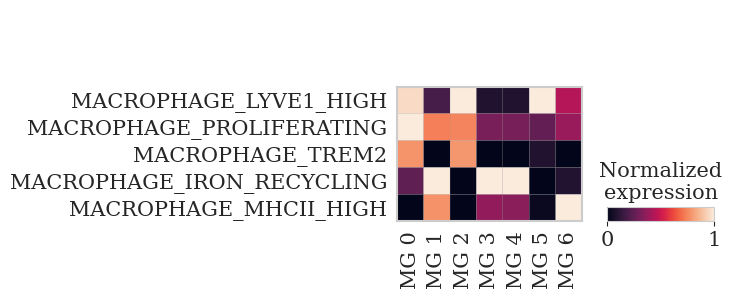

In [54]:
cat_order=['MACROPHAGE_LYVE1_HIGH',
           'MACROPHAGE_PROLIFERATING',
           'MACROPHAGE_TREM2',
           'MACROPHAGE_IRON_RECYCLING',
           'MACROPHAGE_MHCII_HIGH',
           ]
with plt.rc_context():
    sc.pl.matrixplot(compressed_adata,
                  var_names=metagene_names,
                  groupby='celltype_annotation',
                  standard_scale='var',
                  categories_order=cat_order,
                  colorbar_title='Normalized\nexpression',
                  show=False,)
    plt.show()

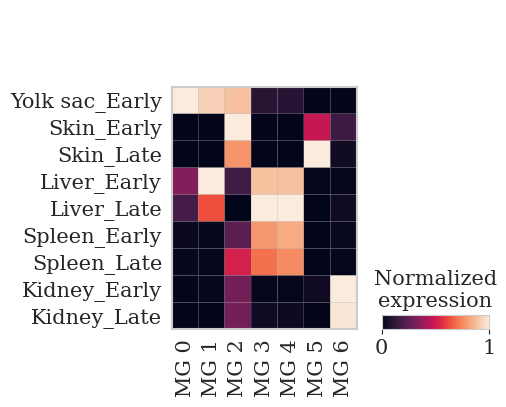

In [55]:
cat_order=['Yolk sac_Early',
           'Skin_Early',
           'Skin_Late',
           'Liver_Early',
           'Liver_Late',
           'Spleen_Early',
           'Spleen_Late',
           'Kidney_Early',
           'Kidney_Late',
           ]

with plt.rc_context():
    sc.pl.matrixplot(compressed_adata,
                  var_names=metagene_names,
                  groupby=['Organ', 'Development_stage'],
                  standard_scale='var',
                  categories_order=cat_order,
                  colorbar_title='Normalized\nexpression',
                  show=False,)
    plt.show()